In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os, sys
import h5py

sys.path.append(os.getcwd().replace('/notebooks','/src'))

import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset, Subset, DataLoader
from dataset_utils import H5DatasetDNN, split_dataset

import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import time

/home/rusack/shared/.conda/env/torch1.9/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/panfs/jay/groups/2/rusack/shared/.conda/env/torch1.9/lib/python3.8/site-packages/torchvision/_C.so
/panfs/jay/groups/2/rusack/shared/.conda/env/torch1.9/lib/python3.8/site-packages/torchvision/image.so


In [2]:
import pickle

In [3]:
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


In [4]:
HGCAL_X_Min = -36
HGCAL_X_Max = 36

HGCAL_Y_Min = -36
HGCAL_Y_Max = 36

HGCAL_Z_Min = 13
HGCAL_Z_Max = 265

HGCAL_E_Min = 0
HGCAL_E_Max = 2727

NHITS_Max = 2000

In [5]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [6]:
!ls /home/rusack/shared/hdf5/hgcal_electron/flat_0001

hgcal_electron_data_0001.h5  hgcal_electron_data_0001_dataset.pt


In [7]:
# Root directory for dataset
#input_file = "/home/rusack/shared/hdf5/hgcal_electron/flat_0001/hgcal_electron_data_0001.h5"
input_file = "/home/rusack/shared/hdf5/hgcal_electron/hgcal_electron_data_test.h5"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 15

# Number of channels in the training images. 28 corresponding to all the layers in CE-E
nc = 28

# Size of z latent vector (i.e. size of generator input)
nz = 50

# Size of feature maps in generator
ngf = 15

# Size of feature maps in discriminator
ndf = 15

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

In [8]:
class GANDataset(Dataset):

    def __init__(self, filepath):
        if not os.path.exists(filepath):
            print('FIle does not exist!')
        
        self.nevents = 0
        self.input_size = (15,15,28)
        self.dataset_size = 0
        self.data = None
        self.targets = None
        self.prepare()
    
    def normalize(self, data, var='xarray'):
        '''
        function to normalize variables
        '''
        limits = {
            'xarray': [HGCAL_X_Min, HGCAL_X_Max],
            'yarray': [HGCAL_X_Min, HGCAL_X_Max],
            'zarray': [HGCAL_Z_Min, HGCAL_Z_Max],
            'energy': [HGCAL_E_Min, HGCAL_E_Max]
        }
        
        return (data-limits[var][0])/(limits[var][1]-limits[var][0])
    
    def set_input_size(self, input_):
        self.input_size = input_
    
    def __len__(self):
        return self.nevents
    
    def __getitem__(self, index=1):
        return self.data[index], self.targets[index]
    
    def get_torched_element(self, x):
        x = ak.to_numpy(x)
        return Data(x=torch.from_numpy(x))
    
    def prepare(self):
        """
        Prepapre dataset
        """
        return

In [10]:
class H5DatasetGAN(GANDataset):

    def __init__(self, h5_path):
        if os.path.exists(h5_path):
            self.h5_file = h5py.File(h5_path, 'r')
        else:
            print('File does not exist!')
        
        self.input_size = (15,15,28)
        self.offset_u = 7
        self.offset_v = 7
        self.d = 1.1220959888872364 # distance between two cells (scale)
        self.dataset_size = 0
        self.data = None
        self.targets = None
        self.prepare()
    
    def prepare(self):
        
        sqtr = np.sqrt(3)
        
        nhits = np.asarray(self.h5_file['nhits'], dtype=int)
        self.targets = np.ones_like(nhits)
        self.nevents = len(nhits)

        rechit_x = np.asarray(self.h5_file['rechit_x']).astype('float32')
        rechit_y = np.asarray(self.h5_file['rechit_y']).astype('float32')
        rechit_z = np.asarray(self.h5_file['rechit_z']).astype('float32')
        rechit_energy = np.asarray(self.h5_file['rechit_energy']).astype('float32')
        
        layers = np.unique(rechit_z)
        
        rechit_u = self.offset_u+2*(rechit_x/self.d)/sqtr
        rechit_v = self.offset_v+(rechit_y/self.d)-(rechit_x/self.d)/sqtr
        
        rechit_u = ak.unflatten(array=rechit_u, counts=nhits)
        rechit_v = ak.unflatten(array=rechit_v, counts=nhits)
        zarray = ak.unflatten(array=rechit_z, counts=nhits)

        rechit_energy = self.normalize(rechit_energy, var='energy')
        energy = ak.unflatten(counts=nhits, array=rechit_energy)
        ptcloud = ak.zip((rechit_u, rechit_v, zarray, energy))
        img = list(map(lambda x: np.array([np.histogram2d(np.array(x[x["2"]==l]["0"]), np.array(x[x["2"]==l]["1"]),
                                                     bins=(15,15), range=((0,15),(0,15)), 
                                                     weights=np.array(x[x["2"]==l]["3"]))[0] for l in layers]), ptcloud))
        
        self.data = np.array(img)

In [11]:
class PklDatasetGAN(GANDataset):
    
    def __init__(self, pickle_path):

        self.pickle_list = ['rechit_energy', 'rechit_x', 'rechit_y', 'rechit_z', 'all_target']
        self.arrays = {}
        self.input_size = (15,15,28)
        self.offset_u = 7
        self.offset_v = 7
        self.d = 1.1220959888872364 # distance between two cells (scale)
        self.dataset_size = 0
        self.data = None
        self.targets = None
        
        if os.path.exists(pickle_path):
            for pkl in self.pickle_list:
                with open('%s/%s.pickle' % (pickle_path, pkl), 'rb') as fpkl_:
                    self.arrays[pkl] = pickle.load(fpkl_)
        else:
            print('Files do not exist!')
        self.arrays['nhits'] = ak.count(self.arrays['rechit_x'], axis=1)
        self.prepare()
          
    def prepare(self):
        sqtr = np.sqrt(3)
        
        nhits = self.arrays['nhits']
        self.targets = np.ones_like(nhits)
        self.nevents = len(nhits)

        rechit_x = self.arrays['rechit_x']
        rechit_y = self.arrays['rechit_y']
        rechit_z = self.arrays['rechit_z']
        rechit_energy = self.arrays['rechit_energy']
        
        layers = np.unique(np.asarray(ak.flatten(rechit_z)))
        
        rechit_u = self.offset_u+2*(rechit_x/self.d)/sqtr
        rechit_v = self.offset_v+(rechit_y/self.d)-(rechit_x/self.d)/sqtr
        rechit_energy = self.normalize(rechit_energy, var='energy')

        ptcloud = ak.zip((rechit_u, rechit_v, rechit_z, rechit_energy))
        img = list(map(lambda x: np.array([np.histogram2d(np.array(x[x["2"]==l]["0"]), np.array(x[x["2"]==l]["1"]),
                                                     bins=(15,15), range=((0,15),(0,15)), 
                                                     weights=np.array(x[x["2"]==l]["3"]))[0] for l in layers]), ptcloud))
        
        self.data = np.array(img)

In [12]:
EPOCHS = 50
TRAIN_BATCH_SIZE = 128
LAYERS = [28, 40, 1] # shape of DNN
LRATE = 1e-3 # learning rate
TRAINING_FOLDER="../training/gan_test"

In [13]:
# create a directory if it doesn't exist
if not os.path.exists(TRAINING_FOLDER):
    os.system('mkdir -p {}'.format(TRAINING_FOLDER))

In [14]:
time_start = time.time()
dataset = H5DatasetGAN(input_file)
train_test_datasets = split_dataset(dataset)

X = train_test_datasets['train']
Y = train_test_datasets['test']

dataloaders = { 'train': torch.utils.data.DataLoader(X, TRAIN_BATCH_SIZE, shuffle=True),
                'test': torch.utils.data.DataLoader(Y, len(Y), shuffle=True)}
print(time.time()-time_start)

0.6497609615325928


In [15]:
for step, (x, y) in enumerate(dataloaders['train']):
    print(step, x.shape)
    break

0 torch.Size([8, 28, 15, 15])


In [119]:
!ls /home/rusack/shared/pickles/hgcal_electron/flat_0000

all_target.pickle    all_valididx.pickle  rechit_energy.pickle	rechit_y.pickle
all_trainidx.pickle  cartfeat.pickle	  rechit_x.pickle	rechit_z.pickle


In [16]:
time_start = time.time()
dataset = PklDatasetGAN('/home/rusack/shared/pickles/hgcal_electron/data/ntuple_457')
train_test_datasets = split_dataset(dataset)

X = train_test_datasets['train']
Y = train_test_datasets['test']

dataloaders = { 'train': torch.utils.data.DataLoader(X, TRAIN_BATCH_SIZE, shuffle=True),
                'test': torch.utils.data.DataLoader(Y, len(Y), shuffle=True)}
print(time.time()-time_start)

135.77794361114502


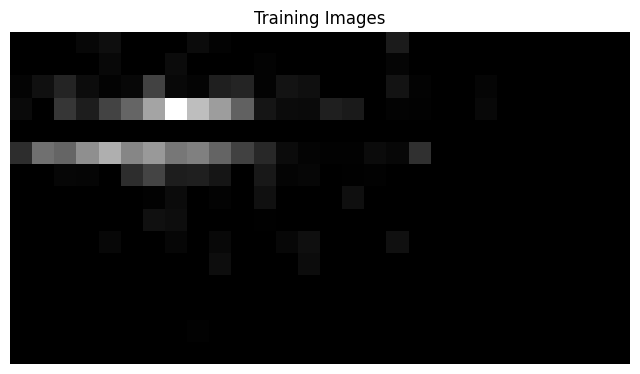

In [17]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloaders['train']))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(torch.transpose(vutils.make_grid(torch.sum(x[0][:,:], axis=2), normalize=True), 0, 2))
#plt.imshow(ak.sum(x[7].numpy(), axis=2))

In [18]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [19]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            #nn.ConvTranspose2d(ngf * 8, ngf * 2, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ngf * 2),
            #nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            #nn.ConvTranspose2d( ngf * 8, ngf * 2, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ngf * 2),
            #nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 8, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 3, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
    

In [20]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(50, 120, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(120, 15, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(15, 28, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)


In [21]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 15 x 15``
            nn.Conv2d(nc, ndf, 3, 2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 3, 2, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, 1, 2, 2, bias=False),
            #nn.BatchNorm2d(ndf * 4),
            #nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            #nn.Conv2d(ndf * 4, ndf * 8, 3, 2, bias=False),
            #nn.BatchNorm2d(ndf * 8),
            #nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            #nn.Conv2d(ndf * 8, 1, 3, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [22]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(28, 15, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(15, 30, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(30, 1, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (6): Sigmoid()
  )
)


In [23]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [28]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 500

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloaders['train'], 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        real_cpu = real_cpu.float()
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloaders['train']),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloaders['train'])-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/500][0/17]	Loss_D: 1.0937	Loss_G: 1.0030	D(x): 0.5685	D(G(z)): 0.4083 / 0.3678
[1/500][0/17]	Loss_D: 1.0675	Loss_G: 0.9392	D(x): 0.5970	D(G(z)): 0.4197 / 0.3923
[2/500][0/17]	Loss_D: 0.9465	Loss_G: 1.1631	D(x): 0.5974	D(G(z)): 0.3455 / 0.3137
[3/500][0/17]	Loss_D: 0.9795	Loss_G: 1.1079	D(x): 0.6028	D(G(z)): 0.3683 / 0.3357
[4/500][0/17]	Loss_D: 1.0210	Loss_G: 1.1477	D(x): 0.5575	D(G(z)): 0.3478 / 0.3208
[5/500][0/17]	Loss_D: 1.1791	Loss_G: 0.8895	D(x): 0.5526	D(G(z)): 0.4389 / 0.4131
[6/500][0/17]	Loss_D: 1.1591	Loss_G: 0.8978	D(x): 0.5514	D(G(z)): 0.4271 / 0.4084
[7/500][0/17]	Loss_D: 0.9452	Loss_G: 1.2460	D(x): 0.5590	D(G(z)): 0.2996 / 0.2895
[8/500][0/17]	Loss_D: 1.0871	Loss_G: 1.0184	D(x): 0.5566	D(G(z)): 0.3896 / 0.3623
[9/500][0/17]	Loss_D: 0.8845	Loss_G: 1.2827	D(x): 0.5939	D(G(z)): 0.2984 / 0.2793
[10/500][0/17]	Loss_D: 1.0030	Loss_G: 1.0825	D(x): 0.5872	D(G(z)): 0.3700 / 0.3402
[11/500][0/17]	Loss_D: 1.0045	Loss_G: 1.1080	D(x): 0.5803	D(G(z)): 0.36

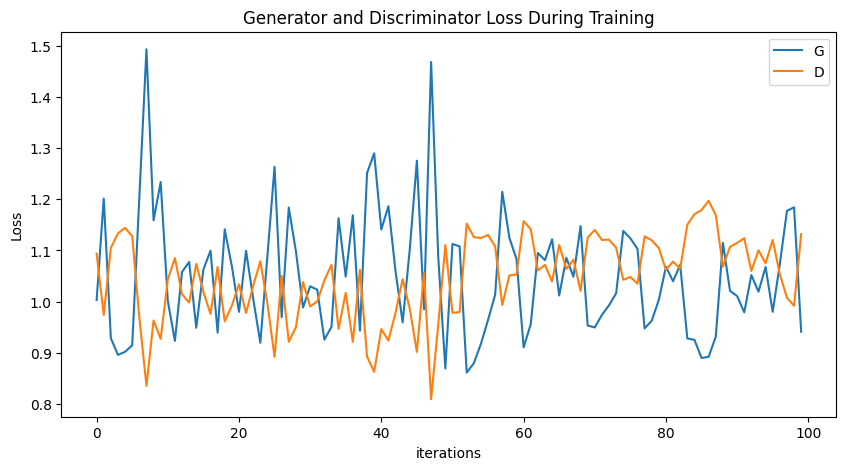

In [33]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses[:100],label="G")
plt.plot(D_losses[:100],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()